## Mortgage default

### Objective: 
The aim of this project is to develop a model to predict if a mortgage from the dataset will default in its remaining lifetime given the information known at the time of its first observation.

In [1]:
# coding: utf-8
# standard import
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

Loading the data in a pandas dataframe

In [2]:
cwd = os.getcwd()
os.chdir(cwd)
data = pd.read_csv("data/mortgage.csv")

## EDA

In [3]:
# Checking names, null values count and data type for each features
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 622489 entries, 0 to 622488
Data columns (total 23 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       622489 non-null  int64  
 1   time                     622489 non-null  int64  
 2   orig_time                622489 non-null  int64  
 3   first_time               622489 non-null  int64  
 4   mat_time                 622489 non-null  int64  
 5   balance_time             622489 non-null  float64
 6   LTV_time                 622219 non-null  float64
 7   interest_rate_time       622489 non-null  float64
 8   hpi_time                 622489 non-null  float64
 9   gdp_time                 622489 non-null  float64
 10  uer_time                 622489 non-null  float64
 11  REtype_CO_orig_time      622489 non-null  int64  
 12  REtype_PU_orig_time      622489 non-null  int64  
 13  REtype_SF_orig_time      622489 non-null  int64  
 14  inve

Removing any duplicates and looking at the dataset.

In [5]:
data = data.drop_duplicates()
data

,id,time,orig_time,first_time,mat_time,balance_time,LTV_time,interest_rate_time,hpi_time,gdp_time,...,REtype_SF_orig_time,investor_orig_time,balance_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time,default_time,payoff_time,status_time
0,1,25,-7,25,113,41303.42,24.498336,9.200,226.29,2.899137,...,1,0,45000.0,715,69.4,9.20,87.03,0,0,0
1,1,26,-7,25,113,41061.95,24.483867,9.200,225.10,2.151365,...,1,0,45000.0,715,69.4,9.20,87.03,0,0,0
2,1,27,-7,25,113,40804.42,24.626795,9.200,222.39,2.361722,...,1,0,45000.0,715,69.4,9.20,87.03,0,0,0
3,1,28,-7,25,113,40483.89,24.735883,9.200,219.67,1.229172,...,1,0,45000.0,715,69.4,9.20,87.03,0,0,0
4,1,29,-7,25,113,40367.06,24.925476,9.200,217.37,1.692969,...,1,0,45000.0,715,69.4,9.20,87.03,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622484,50000,56,16,52,177,517107.42,57.659403,2.664,181.43,1.717053,...,0,0,664000.0,653,80.0,1.75,167.91,0,0,0
622485,50000,57,16,52,177,512274.57,55.359916,2.652,187.20,2.556052,...,0,0,664000.0,653,80.0,1.75,167.91,0,0,0
622486,50000,58,16,52,177,507396.72,54.492206,2.644,188.37,2.868594,...,0,0,664000.0,653,80.0,1.75,167.91,0,0,0
622487,50000,59,16,52,177,502478.87,54.171106,2.638,187.65,2.443648,...,0,0,664000.0,653,80.0,1.75,167.91,0,0,0


### Categorical variables

From the output above we can see that there are no missing values in the dataset. The only data type present are float64 and int64; looking closely to the values of the int64 variables and considering the variables descritpion, there are 7 categoriacal variables: 4 as features and 3 can be used as target.

 - 'REtype_CO_orig_time'
 - 'REtype_PU_orig_time'
 - 'REtype_SF_orig_time'
 - 'investor_orig_time'
 
already encoded as 0-1 variables.

### Target variable

- 'default_time'
- 'payoff_time'
 
already encoded as 0-1 variables, and the last column of the dataset  
- 'status_time'

has three values that encode the values in the previous two columns ('default_time', 'payoff_time') and a third neutral value.
The objective is to predict if a mortgage will default: 'default_time' is selected as target variable and 'payoff_time' and 'status_time' are dropped.<br>

This is a binary classification problem: the model will predict the probabilities of default and with a threshold (default is 0.5) will output 1 for those cases for with the predicted probability >= 0.5, it will output 0 otherwise.

The model will consider the observations at the time stamp of first observation and will predict the default during the remaining lifetime, for this the target associated is the observed value of 'default_time' at the last time of observation available in the dataset.

### Numerical variables

In [6]:
# list of names for numerical variables
numerical_var = ['id', 'time', 'orig_time', 'first_time', 'mat_time', 'balance_time',
       'LTV_time', 'interest_rate_time', 'hpi_time', 'gdp_time', 'uer_time',
       'balance_orig_time', 'FICO_orig_time', 'LTV_orig_time', 'Interest_Rate_orig_time', 'hpi_orig_time']

Summary statistics for the numerical variables

In [7]:
data[numerical_var].describe()

,id,time,orig_time,first_time,mat_time,balance_time,LTV_time,interest_rate_time,hpi_time,gdp_time,uer_time,balance_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time
count,622184.000000,622184.000000,622184.000000,622184.000000,622184.000000,6.221840e+05,621914.000000,622184.000000,622184.000000,622184.000000,622184.000000,6.221840e+05,622184.000000,622184.000000,622184.000000,622184.000000
mean,25141.511718,35.793355,20.572040,24.610077,137.214948,2.460287e+05,83.087502,6.702738,184.114951,1.381087,6.516699,2.563064e+05,673.597376,78.977313,5.649323,198.126695
std,13750.913602,11.577917,7.616133,6.739121,19.523464,2.141736e+05,24.965346,2.079648,27.651779,1.965125,1.921686,2.197387e+05,71.729178,10.125992,2.978715,33.965424
min,1.000000,1.000000,-40.000000,1.000000,18.000000,0.000000e+00,0.000000,0.000000,107.830000,-4.146711,3.800000,0.000000e+00,400.000000,50.100000,0.000000,75.710000
25%,13576.000000,27.000000,18.000000,21.000000,137.000000,1.020661e+05,67.117926,5.650000,158.600000,1.104163,4.700000,1.080000e+05,626.000000,75.000000,4.996000,179.450000
50%,24872.000000,34.000000,22.000000,25.000000,142.000000,1.807216e+05,82.258100,6.625000,180.520000,1.850689,5.700000,1.880000e+05,678.000000,80.000000,6.290000,216.770000
75%,37040.000000,44.000000,25.000000,28.000000,145.000000,3.375561e+05,100.642718,7.875000,212.730000,2.694111,8.200000,3.520000e+05,729.000000,80.000000,7.465000,222.390000
max,50000.000000,60.000000,60.000000,60.000000,229.000000,8.701859e+06,803.513550,37.500000,226.290000,5.132464,10.000000,8.000000e+06,840.000000,218.500000,19.750000,226.290000


Excluding the 'id' column, the values of the variables have different scales and ranges and this need to be considered before developing the model.

### Values at the origin of mortgage

All the variable ending in "*_orig_time":
- REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time', 'investor_orig_time', 'balance_orig_time', 'FICO_orig_time', 'LTV_orig_time', 'Interest_Rate_orig_time', 'hpi_orig_time'

present the respective values at the time the mortgage originated (indicated by the value in 'orig_time'), this may be before the first observation in the dataset. Therefore the values is the same for each observation of the same "id".

The same is for the variable 'first_time': it indicates the time of the first observation for each 'id'.

## Dataset cleaning

The dataset need few pre-processing steps before being ready for modelling: dropping columns, selecting observations at 'first_time', setting target 'default_time' at last observation.

In [8]:
# making a copy of the dataset
df = data.copy()

In [9]:
# dropping redundant target columns and 'LTV_time' as suggested in the instruction
df.drop(columns=['payoff_time', 'status_time', 'LTV_time'], inplace = True)

#### Select data at first observation

In [10]:
df_firstObs = df.copy()

In [11]:
df_firstObs.drop(columns=['default_time'], inplace = True)

In [12]:
df_firstObs = df_firstObs[df_firstObs.time == df_firstObs.first_time]

In [13]:
df_firstObs.drop_duplicates(subset=None, keep="first", inplace=True)

In [14]:
df_firstObs['id'].value_counts()

42503    2
42514    2
1        1
33335    1
33327    1
        ..
16669    1
16670    1
16671    1
16672    1
50000    1
Name: id, Length: 50000, dtype: int64

There are some duplicates rows, there are probably data quality problems and we removed these 'id' from the dataset.

In [15]:
id_to_remove = [42514, 42503]
df_firstObs = df_firstObs[~df_firstObs['id'].isin(id_to_remove)]

In [16]:
df_firstObs.shape[0]

49998

#### Select target at last observation

In [17]:
df_target = df.copy()

In [18]:
idx = df_target.groupby(['id'])['time'].transform(max) == df_target['time']

In [19]:
# Checking the values at the latest observation time
df_target[idx].head(10)

,id,time,orig_time,first_time,mat_time,balance_time,interest_rate_time,hpi_time,gdp_time,uer_time,REtype_CO_orig_time,REtype_PU_orig_time,REtype_SF_orig_time,investor_orig_time,balance_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time,default_time
23,1,48,-7,25,113,29087.21,9.200,146.45,2.715903,8.3,0,0,1,0,45000.0,715,69.4,9.200,87.03,1
25,2,26,18,25,138,105654.77,7.680,225.10,2.151365,4.7,0,0,1,0,107200.0,558,80.0,7.680,186.91,0
30,3,29,-6,25,114,44378.60,11.375,217.37,1.692969,4.5,0,0,1,0,48600.0,680,83.6,8.750,89.58,0
65,4,60,-2,25,119,52686.35,10.500,189.82,2.836358,5.7,0,0,1,0,63750.0,587,81.8,10.500,97.99,0
68,5,27,18,25,138,52100.71,9.155,222.39,2.361722,4.4,0,0,1,0,52800.0,527,80.0,9.155,186.91,0
99,6,56,19,25,139,190474.11,6.580,181.43,1.717053,6.6,0,0,1,0,212000.0,670,80.0,6.580,191.42,1
101,7,26,18,25,138,107916.38,9.000,225.10,2.151365,4.7,0,0,1,0,109250.0,601,95.0,9.000,186.91,0
102,8,25,18,25,138,152393.21,7.250,226.29,2.899137,4.7,0,0,1,0,192600.0,663,90.0,7.250,186.91,0
115,9,37,18,25,138,130140.31,8.000,153.35,-4.146711,9.0,0,0,1,0,128000.0,501,80.0,8.000,186.91,1
120,10,29,18,25,139,88046.35,10.230,217.37,1.692969,4.5,0,0,1,0,90000.0,665,80.0,7.200,186.91,1


In [20]:
# select only the columns: 'id' and 'default_time'
df_target = df_target[idx][['id', 'default_time']]

In [21]:
df_target.drop_duplicates(subset=None, keep="first", inplace=True)

In [22]:
df_target

,id,default_time
23,1,1
25,2,0
30,3,0
65,4,0
68,5,0
...,...,...
622452,49996,0
622461,49997,0
622470,49998,0
622479,49999,0


In [23]:
# merging df_firstObs and df_target to obtain the final clean dataset
mortgage_clean = pd.merge(df_firstObs, df_target, how="left", on="id")

In [24]:
mortgage_clean.drop_duplicates(['id'], keep="first", inplace=True)

The variables 'id' and 'first_time' are no longer needed, the timestamp of first observation ('time') could be important to indicate if mortgages observed for the first time at a specific timestamp will default more than others.

In [25]:
mortgage_clean.drop(columns=['id', 'first_time'], inplace = True)

In [26]:
mortgage_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49998 entries, 0 to 49997
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   time                     49998 non-null  int64  
 1   orig_time                49998 non-null  int64  
 2   mat_time                 49998 non-null  int64  
 3   balance_time             49998 non-null  float64
 4   interest_rate_time       49998 non-null  float64
 5   hpi_time                 49998 non-null  float64
 6   gdp_time                 49998 non-null  float64
 7   uer_time                 49998 non-null  float64
 8   REtype_CO_orig_time      49998 non-null  int64  
 9   REtype_PU_orig_time      49998 non-null  int64  
 10  REtype_SF_orig_time      49998 non-null  int64  
 11  investor_orig_time       49998 non-null  int64  
 12  balance_orig_time        49998 non-null  float64
 13  FICO_orig_time           49998 non-null  int64  
 14  LTV_orig_time         

The clean dataset has 49998 observations: 16 variables and the target variable 'default_time'

In [27]:
mortgage_clean.head()

,time,orig_time,mat_time,balance_time,interest_rate_time,hpi_time,gdp_time,uer_time,REtype_CO_orig_time,REtype_PU_orig_time,REtype_SF_orig_time,investor_orig_time,balance_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time,default_time
0,25,-7,113,41303.42,9.200,226.29,2.899137,4.7,0,0,1,0,45000.0,715,69.4,9.200,87.03,1
1,25,18,138,105826.38,7.680,226.29,2.899137,4.7,0,0,1,0,107200.0,558,80.0,7.680,186.91,0
2,25,-6,114,44866.18,10.500,226.29,2.899137,4.7,0,0,1,0,48600.0,680,83.6,8.750,89.58,0
3,25,-2,119,61031.10,10.500,226.29,2.899137,4.7,0,0,1,0,63750.0,587,81.8,10.500,97.99,0
4,25,18,138,52295.07,9.155,226.29,2.899137,4.7,0,0,1,0,52800.0,527,80.0,9.155,186.91,0


In [28]:
mortgage_clean['default_time'].value_counts()

0    34845
1    15153
Name: default_time, dtype: int64

The dataset is unbalanced: the target variable indicate that the number of non default observations is more than twice the number of the defalt observations. This needs to be considered when chosing the metric for model evaluation.

## Modelling

In [29]:
X = mortgage_clean.iloc[:, :16].copy()
y = mortgage_clean['default_time'].copy()

In [30]:
# split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((34998, 16), (15000, 16), (34998,), (15000,))

### 1) Develop Model-1

A Random Forest Classifier model is selected: it is an ensemble method and a tree-based model. Ensemble methods have in general better performance than other methods because they made prediction using an overall result from a great number of simpler models (in the case of a classifier a majority vote is used as overall measure to assign the class).  
It uses partitioning of the variables space, it does not require variables normalisation. 

A basic random forest model is defined and a random_state is set for reproducibility and n_jobs is set for jobs to run in parallel.

In [31]:
model_1 = RandomForestClassifier(random_state=147, n_jobs=-1)

Grid search is used to find the best set of hyper-parameters for the model. Cross-validation is used for each combination of values in the parameters dictionary. The recall is chosen as scoring metric: it tells how good is the classifier in finding all the positive (default) observations.

In [32]:
parameters = {
              'max_depth': [5, 10, 20],
              'n_estimators': [200, 400, 600]
}

In [33]:
cv_model_1 = GridSearchCV(model_1, param_grid = parameters, cv=10, verbose=1, scoring='recall')

In [34]:
cv_model_1.fit(X_train, y_train)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=147),
             param_grid={'max_depth': [5, 10, 20],
                         'n_estimators': [200, 400, 600]},
             scoring='recall', verbose=1)

The best parameters combination found by grid search algorithm and the best estimator:

In [35]:
print(cv_model_1.best_params_)
print(cv_model_1.best_estimator_)

{'max_depth': 20, 'n_estimators': 200}
RandomForestClassifier(max_depth=20, n_estimators=200, n_jobs=-1,
                       random_state=147)


The best model is fitted and used to predict the taget on the test set.

In [36]:
model_1_best = cv_model_1.best_estimator_

In [37]:
model_1_best.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, n_estimators=200, n_jobs=-1,
                       random_state=147)

The predictions are made on the test dataset with our model using the predict() method to return the class, the underlying default calculation uses the probability score and the threshold of 0.5 for positiveness.

In [38]:
y_pred_best = model_1_best.predict(X_test)

In [39]:
print(classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.78      0.87      0.82     10456
           1       0.60      0.44      0.51      4544

    accuracy                           0.74     15000
   macro avg       0.69      0.65      0.66     15000
weighted avg       0.73      0.74      0.73     15000



In [40]:
print("model_1_best metrics for performance")
print("Recall: ", recall_score(y_test, y_pred_best), "\nPrecision: ", precision_score(y_test, y_pred_best))

model_1_best metrics for performance
Recall:  0.4381602112676056 
Precision:  0.5962863132674453


The confusion matrix shows us how the model classify the test observations.

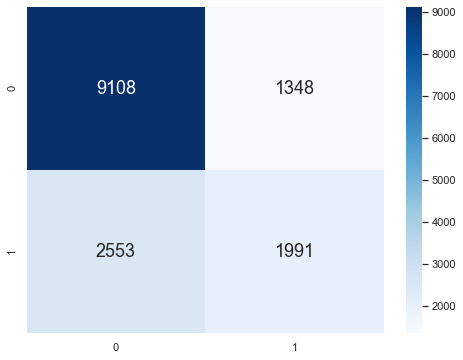

In [41]:
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=[8, 6])
sns.heatmap(cm, annot=cm, fmt='g', cmap='Blues', annot_kws={"size": 18})

### 2) Identify which variables are the most predictive of mortgage default

feature_importances_ values for each variable are extracted from model_1_best in the prediction of mortgage default

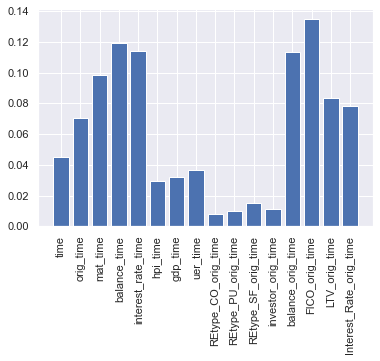

In [42]:
plt.bar(X_train.columns, model_1_best.feature_importances_)
plt.xticks(rotation=90)
plt.show()

In [43]:
importance = pd.DataFrame()
importance['cols'] = X_train.columns
importance['importance'] = model_1_best.feature_importances_
importance.sort_values(by='importance', ascending=False, inplace=True)
importance

,cols,importance
13,FICO_orig_time,0.134773
3,balance_time,0.119057
4,interest_rate_time,0.114135
12,balance_orig_time,0.113390
2,mat_time,0.098458
14,LTV_orig_time,0.083740
15,Interest_Rate_orig_time,0.078117
1,orig_time,0.070436
0,time,0.045095
7,uer_time,0.036583


The most important variable is the 'FICO_orig_time' with an importance of 0.134773

### 3) Identify any highly correlated pairs of variables

Correlation between variables assume an underlying linear relationship between them, this is an 'a priori' assumption on the form of reletionship between the variables<br>
Correlation matrix for the variables

In [45]:
corr_mx = mortgage_clean.iloc[:, :16].corr()
corr_mx

,time,orig_time,mat_time,balance_time,interest_rate_time,hpi_time,gdp_time,uer_time,REtype_CO_orig_time,REtype_PU_orig_time,REtype_SF_orig_time,investor_orig_time,balance_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time
time,1.000000,0.608801,0.324953,0.107368,-0.123508,0.230207,-0.648211,0.397733,0.010362,-0.000980,-0.017708,-0.018866,0.115489,0.029412,0.001100,0.051418
orig_time,0.608801,1.000000,0.585898,0.230231,-0.112873,0.421183,-0.481192,-0.062745,0.028506,0.058906,-0.050854,0.031786,0.223251,0.150874,-0.032312,-0.011279
mat_time,0.324953,0.585898,1.000000,0.203762,-0.082527,0.287478,-0.299292,-0.109355,0.030354,0.064413,-0.037712,-0.022114,0.191187,0.068435,0.056364,-0.130936
balance_time,0.107368,0.230231,0.203762,1.000000,-0.279353,0.108018,-0.080811,-0.045570,-0.010453,0.096408,-0.046212,-0.120515,0.996189,0.321133,-0.188571,-0.103237
interest_rate_time,-0.123508,-0.112873,-0.082527,-0.279353,1.000000,-0.074434,-0.110249,-0.239417,-0.047329,-0.092882,0.047995,0.032514,-0.284502,-0.427728,0.182110,0.256476
hpi_time,0.230207,0.421183,0.287478,0.108018,-0.074434,1.000000,-0.066335,-0.529347,0.041025,0.056254,-0.072140,0.026207,0.102336,0.127035,0.006782,-0.009940
gdp_time,-0.648211,-0.481192,-0.299292,-0.080811,-0.110249,-0.066335,1.000000,-0.106394,-0.011859,0.003618,-0.024260,0.011011,-0.082815,0.021998,-0.003954,-0.085856
uer_time,0.397733,-0.062745,-0.109355,-0.045570,-0.239417,-0.529347,-0.106394,1.000000,-0.027534,-0.041356,0.002995,-0.029231,-0.033720,-0.036295,0.010802,-0.128206
REtype_CO_orig_time,0.010362,0.028506,0.030354,-0.010453,-0.047329,0.041025,-0.011859,-0.027534,1.000000,-0.095387,-0.338613,0.024215,-0.011113,0.090732,0.005141,-0.024094
REtype_PU_orig_time,-0.000980,0.058906,0.064413,0.096408,-0.092882,0.056254,0.003618,-0.041356,-0.095387,1.000000,-0.465207,-0.017180,0.094904,0.123879,-0.003408,-0.027726


A heatmap visual is used to highlight the values

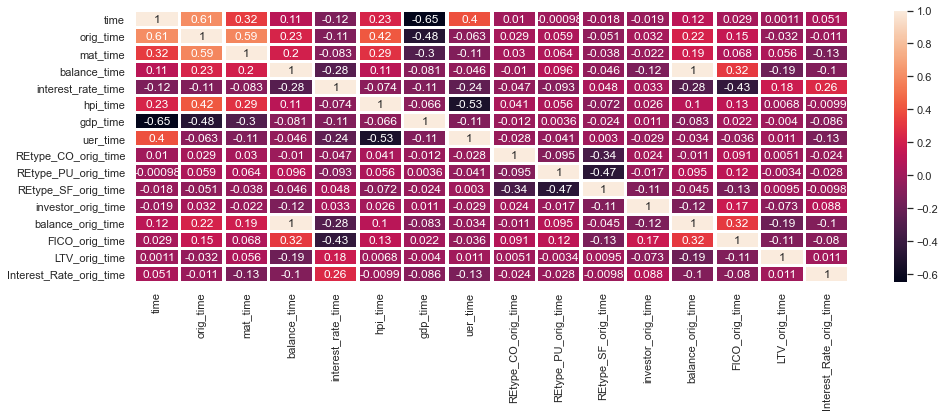

In [46]:
plt.figure(figsize = (16, 5))
sns.heatmap(corr_mx, annot=True, linewidths=2.5)
plt.show()

balance_time - balance_orig_time: highly positive correlation of 0.996189  
time - gdp_time: negative correlation of -0.648211  
time - orig_time: positive correlation of 0.608801  
orig_time - mat_time: positive correlation of 0.585898  
uer_time - hpi_time: negative correlation of -0.529347  

### 4) Develop a second model (Model-2) that uses only 5 of the provided variables

The 5 most important variables are selected based on the importance calculated at point 2) and retrieved to be used to develop the second model.

In [47]:
importance.head()

,cols,importance
13,FICO_orig_time,0.134773
3,balance_time,0.119057
4,interest_rate_time,0.114135
12,balance_orig_time,0.113390
2,mat_time,0.098458


In [48]:
var_5 = importance['cols'].head().values

In [49]:
X_var5 = pd.DataFrame(mortgage_clean[var_5])

In [50]:
# split train and test data
X_train_5, X_test_5, y_train, y_test = train_test_split(X_var5, y, test_size=0.30, random_state=17)
X_train_5.shape, X_test_5.shape, y_train.shape, y_test.shape

((34998, 5), (15000, 5), (34998,), (15000,))

A Random Forest classifier is used again with the reduced dataset: the same parameters dictionary and grid search are used for better comparison of performance.

In [53]:
model_2 = RandomForestClassifier(random_state=147, n_jobs=-1)

In [54]:
cv_model_2 = GridSearchCV(model_2, param_grid = parameters, cv=10, verbose=1, scoring='recall')

In [55]:
cv_model_2.fit(X_train_5, y_train)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=147),
             param_grid={'max_depth': [5, 10, 20],
                         'n_estimators': [200, 400, 600]},
             scoring='recall', verbose=1)

In [56]:
print(cv_model_2.best_params_)
print(cv_model_2.best_estimator_)

{'max_depth': 20, 'n_estimators': 600}
RandomForestClassifier(max_depth=20, n_estimators=600, n_jobs=-1,
                       random_state=147)


In [57]:
model_2_best = cv_model_2.best_estimator_

In [58]:
model_2_best.fit(X_train_5, y_train)

RandomForestClassifier(max_depth=20, n_estimators=600, n_jobs=-1,
                       random_state=147)

In [59]:
y_pred_5 = model_2_best.predict(X_test_5)

In [60]:
print(classification_report(y_test, y_pred_5))

              precision    recall  f1-score   support

           0       0.77      0.86      0.81     10456
           1       0.56      0.40      0.47      4544

    accuracy                           0.72     15000
   macro avg       0.66      0.63      0.64     15000
weighted avg       0.70      0.72      0.71     15000



In [61]:
print("model_2_best metrics for performance")
print("Recall: ", recall_score(y_test, y_pred_5), "\nPrecision: ", precision_score(y_test, y_pred_5))

model_2_best metrics for performance
Recall:  0.4038292253521127 
Precision:  0.5558921538927598


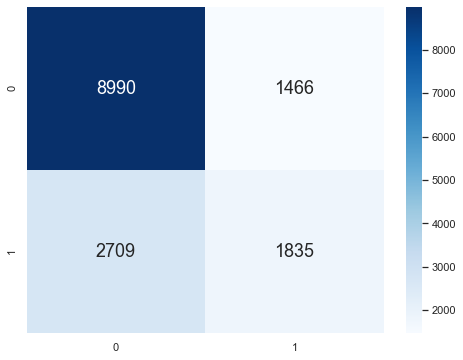

In [62]:
cm_2 = confusion_matrix(y_test, y_pred_5)
plt.figure(figsize=[8, 6])
sns.heatmap(cm_2, annot=cm_2, fmt='g', cmap='Blues', annot_kws={"size": 18})

### 5) Models comparison

Recall has been chosen as metrics to guide the grid serach cross-validation: it indicates how good is the classifier at finding all the positive (default) observations.

The dataset target is unbalanced: 34845 nondefault (0) and 15153 default (1) observations. In this case a the accuracy of the classifier is not a good metric: a model that only predicts nondefault for any observation will have an accuracy of 69.7%, but it would be a wrong model.

The banking institution wants to avoid to buy mortgages that have a high risk to default. Therefore it is more interested in a model that is very good at finding all the mortgages that have high probability of default (positive), therefore a high recall.

Precision also is considered: it indicates how good is the classifier at correctly identifying positive observations.

Let's review the performance metrics for both models:

In [63]:
print("model_1_best metrics for performance")
print("Recall: ", recall_score(y_test, y_pred_best), "\nPrecision: ", precision_score(y_test, y_pred_best))

model_1_best metrics for performance
Recall:  0.4381602112676056 
Precision:  0.5962863132674453


In [64]:
print("model_2_best metrics for performance")
print("Recall: ", recall_score(y_test, y_pred_5), "\nPrecision: ", precision_score(y_test, y_pred_5))

model_2_best metrics for performance
Recall:  0.4038292253521127 
Precision:  0.5558921538927598


Both models do not have a high recall or precision and seem to underfit the data. Model-1 performs slightly better than Model-2:
- Recall: 
    - Model-1 0.438 is higher than Model-2  0.404
- Precision: 
   -  Model-1  0.596 is higher than Model-2  0.556

Possible causes of poor performance of the models:
- selecting only the 5 most important variables leaves out important information for prediction
- random split of the data has biased the train and test set
- the models, as tested, are not yet customized for this dataset: more hyperparameters tuning is required
- Random Forest is not the best model to be used with this dataset

## Possible further development

There are several options for improvement:

- use a higher number of estimators, n_estimators (limited to few hundreds in this notebook for computation time): the more estimators the more reliable is the prediction and stronger the model
- each observation could be used as first observation and for target the latest value of 'default_time'
- extend GridSearchCV with more parameters and values, use different random_state for train/test split and model definition
- feature engineering: new features can be added to the dataset, e.g. balance_diff  = 'balance_time' - 'balance_orig_time'
- enrichment of the dataset: combining variables from other sources (e.g. demographic data end employment status of borrowers)
- use a different classification model type: k nearest neighbors or support vector machine (SVM), for both the numerical features need to be normalised first